# Benchmarking in the absence of Ground Truth data

Comparing the model prediction with the simulation / experimental data is an excellent way to build confidence in the model predictions. However, in a test scenario, where the model is used in the absence of any ground truth data (true inference setting), it is difficult to estimate whether the model predictions are reasonable and trustworthy. 

In this notebook we provide a few approaches one can take to understand the model behavior in different inference settings and build error estimates. More specifically, we will demonstrate case studies to analyze the sensitivity of the model towards mesh resolution, model checkpoint and explore ways to quantify out-of-sample scenarios. 

## Analyze the model's sensitivity to input (STL) resolution

DoMINO model used in this study takes in the STL file and predicts solution on desired points. We can study how much the model is sensitive to the STL's resolution by creating realizations of the same STL at various mesh densities and distributions.

Let's start by creating a few variations of the 202 sample ID by decimating the mesh, sub-dividing the mesh, etc. We will use `trimesh` to perform these operations. 

In [1]:
import pyvista as pv
import trimesh
import glob
import os

mesh = trimesh.load_mesh("drivaer_202_single_solid.stl")

# Clean-up already existing files
files_to_delete = glob.glob("remeshed_variant_*.stl")
for file_path in files_to_delete:
    os.remove(file_path)
    
# Create a few remeshed variants
for variant in range(8):
    remeshed_mesh = mesh.copy()
    
    if variant == 0:
        target_faces = int(len(remeshed_mesh.faces) * 0.5)
        remeshed_mesh = remeshed_mesh.simplify_quadric_decimation(face_count=target_faces)
        
    elif variant == 1:
        target_faces = int(len(remeshed_mesh.faces) * 0.25)
        remeshed_mesh = remeshed_mesh.simplify_quadric_decimation(face_count=target_faces)
        
    elif variant == 2:
        remeshed_mesh = remeshed_mesh.subdivide()
              
    elif variant == 3:
        remeshed_mesh.update_faces(remeshed_mesh.nondegenerate_faces())
        remeshed_mesh.update_faces(remeshed_mesh.unique_faces())
        remeshed_mesh.remove_infinite_values()
        remeshed_mesh.remove_unreferenced_vertices()
        
    elif variant == 4:
        remeshed_mesh.fix_normals()
        
    elif variant == 5:
        target_faces = int(len(remeshed_mesh.faces) * 0.7)
        remeshed_mesh = remeshed_mesh.simplify_quadric_decimation(face_count=target_faces)
        remeshed_mesh = remeshed_mesh.subdivide()
        
    elif variant == 6:
        remeshed_mesh = remeshed_mesh.subdivide()
        target_faces = int(len(remeshed_mesh.faces) * 0.6)
        remeshed_mesh = remeshed_mesh.simplify_quadric_decimation(face_count=target_faces)
        
    elif variant == 7:
        remeshed_mesh.update_faces(remeshed_mesh.nondegenerate_faces())
        remeshed_mesh.update_faces(remeshed_mesh.unique_faces())
        remeshed_mesh.remove_infinite_values()
        target_faces = int(len(remeshed_mesh.faces) * 0.8)
        remeshed_mesh = remeshed_mesh.simplify_quadric_decimation(face_count=target_faces)
    
    # Ensure watertight mesh for all variants
    remeshed_mesh.fill_holes()
    remeshed_mesh.update_faces(remeshed_mesh.nondegenerate_faces())
    remeshed_mesh.update_faces(remeshed_mesh.unique_faces())
    remeshed_mesh.remove_infinite_values()
    remeshed_mesh.remove_unreferenced_vertices()
    remeshed_mesh.fix_normals()
    
    # Save the remeshed mesh
    remeshed_mesh.export(f"remeshed_variant_{variant}.stl")

Now that we have these different variations generated, we can run the NIM on each of them and visualize the standard deviation of the fields on a fix set of points. These can be any set of points, for this study, we pick them from the "meshed" version of the original STL, i.e. the `.vtp` file. 

In [2]:
import pyvista as pv
pv.start_xvfb()

mesh = pv.read("./boundary_202.vtp")
mesh

/localhome/local-ktangsali/anaconda3/lib/python3.13/site-packages/pyvista/plotting/utilities/xvfb.py:48: PyVistaDeprecationWarning: This function is deprecated and will be removed in future version of PyVista. Use vtk-osmesa instead.
  warnings.warn(


PolyData (0x755742af39a0)
  N Cells:    8883343
  N Points:   8902069
  N Strips:   0
  X Bounds:   -9.240e-01, 3.886e+00
  Y Bounds:   -1.061e+00, 1.061e+00
  Z Bounds:   -3.176e-01, 1.074e+00
  N Arrays:   5

In [3]:
import numpy as np
import os, time
from physicsnemo.cfd.bench.interpolation.interpolate_mesh_to_pc import (
    _create_nbrs_surface,
    _interpolate,
)
from physicsnemo.cfd.inference.domino_nim import call_domino_nim

stl_files = glob.glob("remeshed_variant_*.stl")

pMeanTrimPred = []
wallShearStressMeanTrimPred = []
for i, stl_file in enumerate(stl_files):
    print(f"Processing {i}")
    output_dict = call_domino_nim(
        stl_path=stl_file,
        inference_api_url="http://localhost:8000/v1/infer",
        data={
            "stream_velocity": "38.89",
            "stencil_size": "1",
            "point_cloud_size": "500000",
        },
        verbose=True,
    )

    # Interpolate the results of the NIM onto the mesh points
    # v2 of NIM will enable inference on custom point clouds, so this step will not be required in future
    start_time = time.time()
    mesh_cell_centers = mesh.cell_centers()
    nbrs_surface = _create_nbrs_surface(
        output_dict["surface_coordinates"][0, :], device="gpu"
    )
    fields = np.concatenate(
        [output_dict["pressure_surface"][0, :], output_dict["wall_shear_stress"][0, :]],
        axis=1,
    )
    fields_interp = _interpolate(
        nbrs_surface, mesh_cell_centers.points, fields, device="gpu", batch_size=10_000_000
    )
    pMeanTrimPred.append(fields_interp[:, 0])
    wallShearStressMeanTrimPred.append(fields_interp[:, 1:4])

mesh

Processing 0
Sending POST request to DoMINO NIM inference API at http://localhost:8000/v1/infer...
Inference complete. Output keys: dict_keys(['sdf', 'coordinates', 'velocity', 'pressure', 'turbulent_kinetic_energy', 'turbulent_viscosity', 'bounding_box_dims', 'surface_coordinates', 'pressure_surface', 'wall_shear_stress', 'drag_force', 'lift_force']).
Processing 1
Sending POST request to DoMINO NIM inference API at http://localhost:8000/v1/infer...
Inference complete. Output keys: dict_keys(['sdf', 'coordinates', 'velocity', 'pressure', 'turbulent_kinetic_energy', 'turbulent_viscosity', 'bounding_box_dims', 'surface_coordinates', 'pressure_surface', 'wall_shear_stress', 'drag_force', 'lift_force']).
Processing 2
Sending POST request to DoMINO NIM inference API at http://localhost:8000/v1/infer...
Inference complete. Output keys: dict_keys(['sdf', 'coordinates', 'velocity', 'pressure', 'turbulent_kinetic_energy', 'turbulent_viscosity', 'bounding_box_dims', 'surface_coordinates', 'press

PolyData (0x755742af39a0)
  N Cells:    8883343
  N Points:   8902069
  N Strips:   0
  X Bounds:   -9.240e-01, 3.886e+00
  Y Bounds:   -1.061e+00, 1.061e+00
  Z Bounds:   -3.176e-01, 1.074e+00
  N Arrays:   5

In [4]:
pMeanTrimPred_mean = np.mean(np.stack(pMeanTrimPred, axis=0), axis=0)
pMeanTrimPred_std = np.std(np.stack(pMeanTrimPred, axis=0), axis=0)
wallShearStressMeanTrimPred_mean = np.mean(np.stack(wallShearStressMeanTrimPred, axis=0), axis=0)
wallShearStressMeanTrimPred_std = np.std(np.stack(wallShearStressMeanTrimPred, axis=0), axis=0)

mesh.cell_data[f"pMeanTrimPred_mean"] = pMeanTrimPred_mean
mesh.cell_data[f"pMeanTrimPred_std"] = pMeanTrimPred_std
mesh.cell_data[f"wallShearStressMeanTrimPred_mean"] = wallShearStressMeanTrimPred_mean
mesh.cell_data[f"wallShearStressMeanTrimPred_std"] = wallShearStressMeanTrimPred_std

2025-08-01 23:17:28.756 ( 251.797s) [    7557909A4740]vtkXOpenGLRenderWindow.:256    ERR| vtkXOpenGLRenderWindow (0x15e76c80): Could not find a decent config

ERROR:root:Could not find a decent config
2025-08-01 23:17:28.757 ( 251.798s) [    7557909A4740]vtkXOpenGLRenderWindow.:502   WARN| vtkXOpenGLRenderWindow (0x15e76c80): Could not find a decent visual



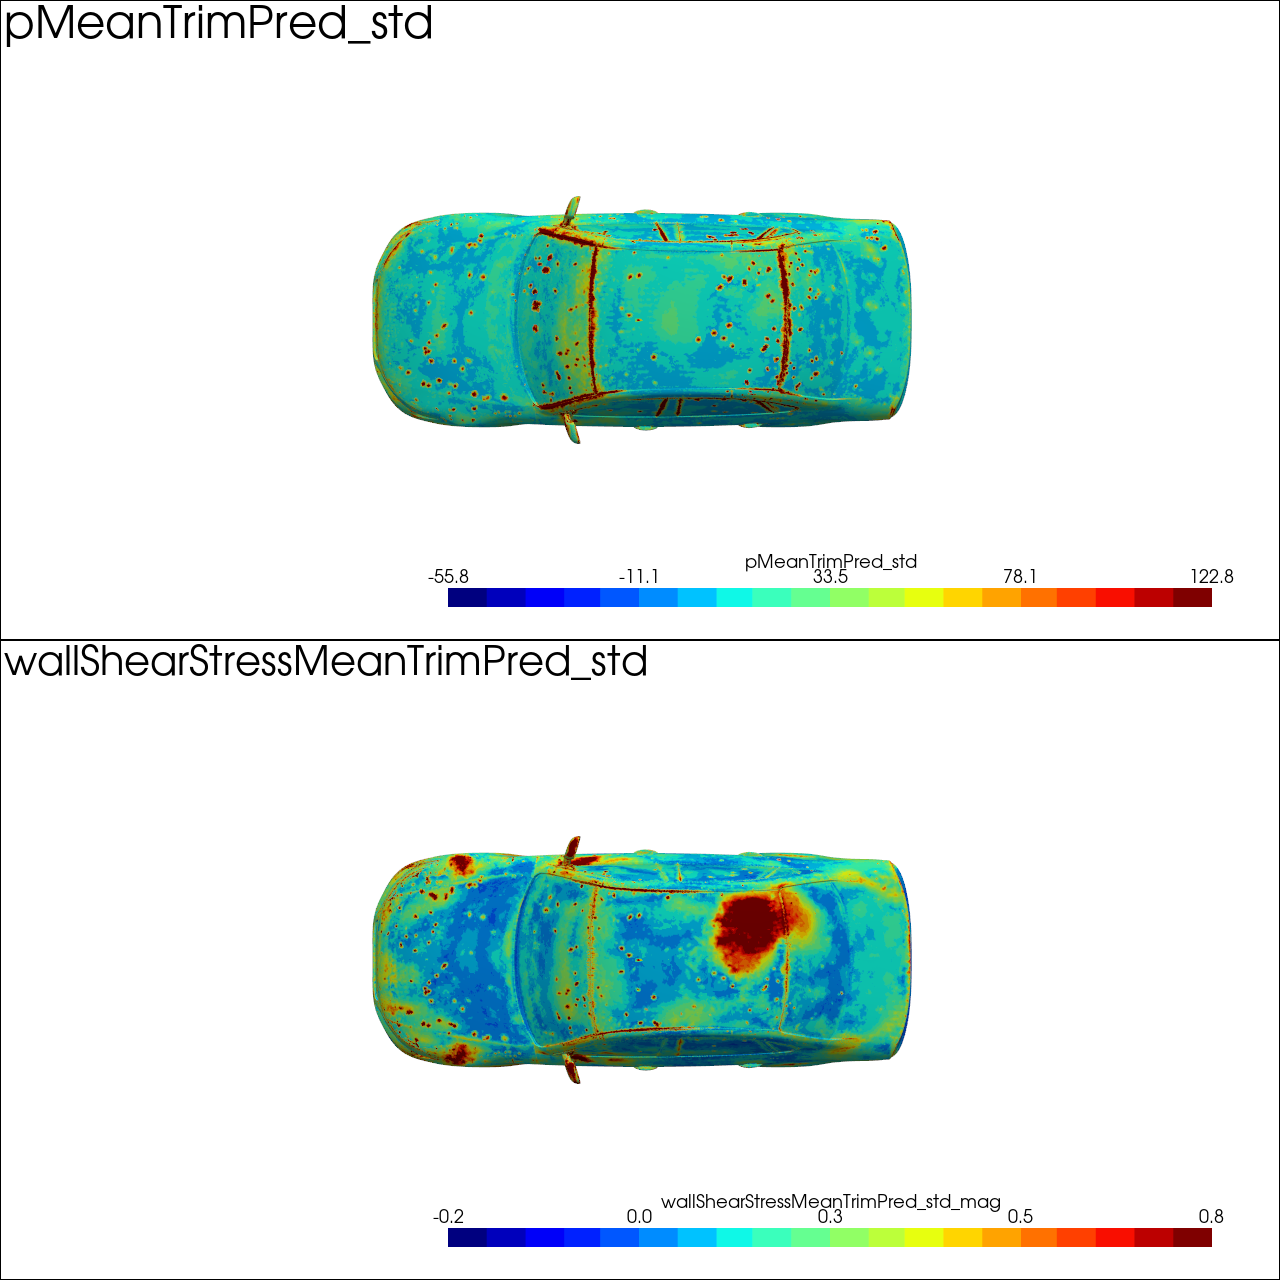

In [6]:
from physicsnemo.cfd.bench.visualization.utils import plot_fields

fields_to_plot = ["pMeanTrimPred_std", "wallShearStressMeanTrimPred_std"]
plotter = plot_fields(mesh, 
    fields_to_plot,
    plot_vector_components=False,
    view="xy",
    dtype="cell",
    cmap="jet",
    lut=20,
    window_size=[1280, 1280],
)
plotter.screenshot("./variations_with_mesh_xy.png")

# Display the image
from IPython.display import Image

Image(filename="./variations_with_mesh_xy.png")

2025-08-01 23:18:28.945 ( 311.986s) [    7557909A4740]vtkXOpenGLRenderWindow.:256    ERR| vtkXOpenGLRenderWindow (0x75560cc92230): Could not find a decent config

ERROR:root:Could not find a decent config
2025-08-01 23:18:28.946 ( 311.987s) [    7557909A4740]vtkXOpenGLRenderWindow.:502   WARN| vtkXOpenGLRenderWindow (0x75560cc92230): Could not find a decent visual



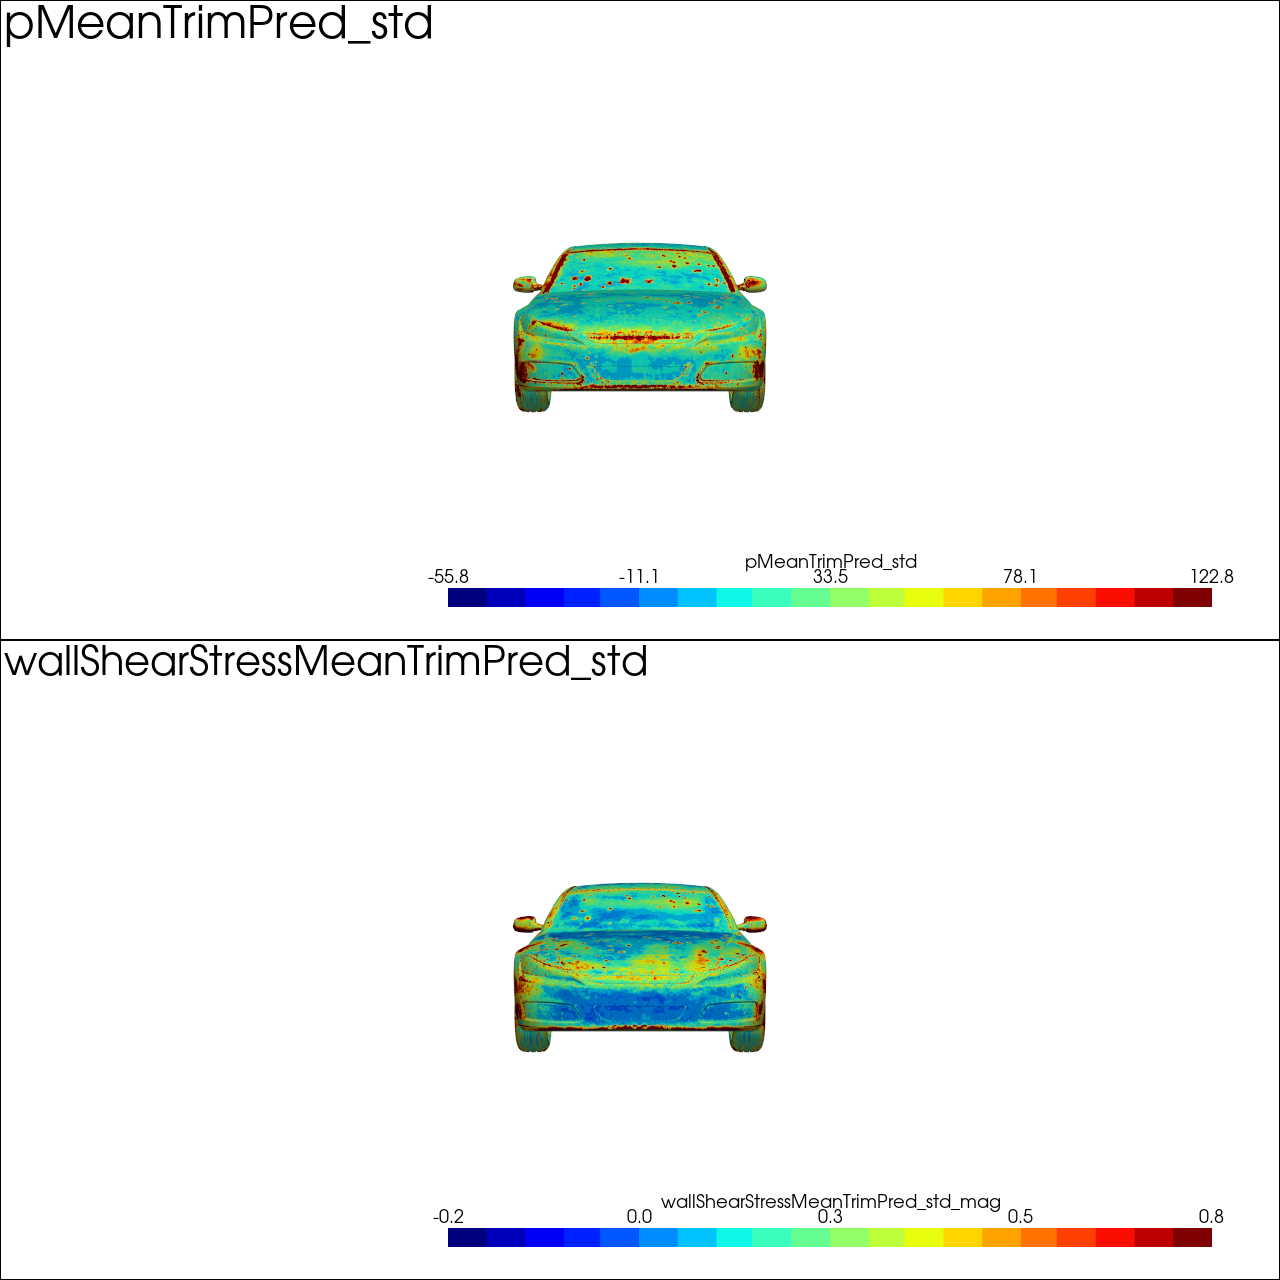

In [9]:
from physicsnemo.cfd.bench.visualization.utils import plot_fields

fields_to_plot = ["pMeanTrimPred_std", "wallShearStressMeanTrimPred_std"]
plotter = plot_fields(mesh, 
    fields_to_plot,
    plot_vector_components=False,
    view="yz",
    view_negative=True,
    dtype="cell",
    cmap="jet",
    lut=20,
    window_size=[1280, 1280],
)
plotter.screenshot("./variations_with_mesh_yz.png")

# Display the image
from IPython.display import Image

Image(filename="./variations_with_mesh_yz.png")

2025-08-01 23:18:38.981 ( 322.022s) [    7557909A4740]vtkXOpenGLRenderWindow.:256    ERR| vtkXOpenGLRenderWindow (0x7553b2311030): Could not find a decent config

ERROR:root:Could not find a decent config
2025-08-01 23:18:38.982 ( 322.023s) [    7557909A4740]vtkXOpenGLRenderWindow.:502   WARN| vtkXOpenGLRenderWindow (0x7553b2311030): Could not find a decent visual



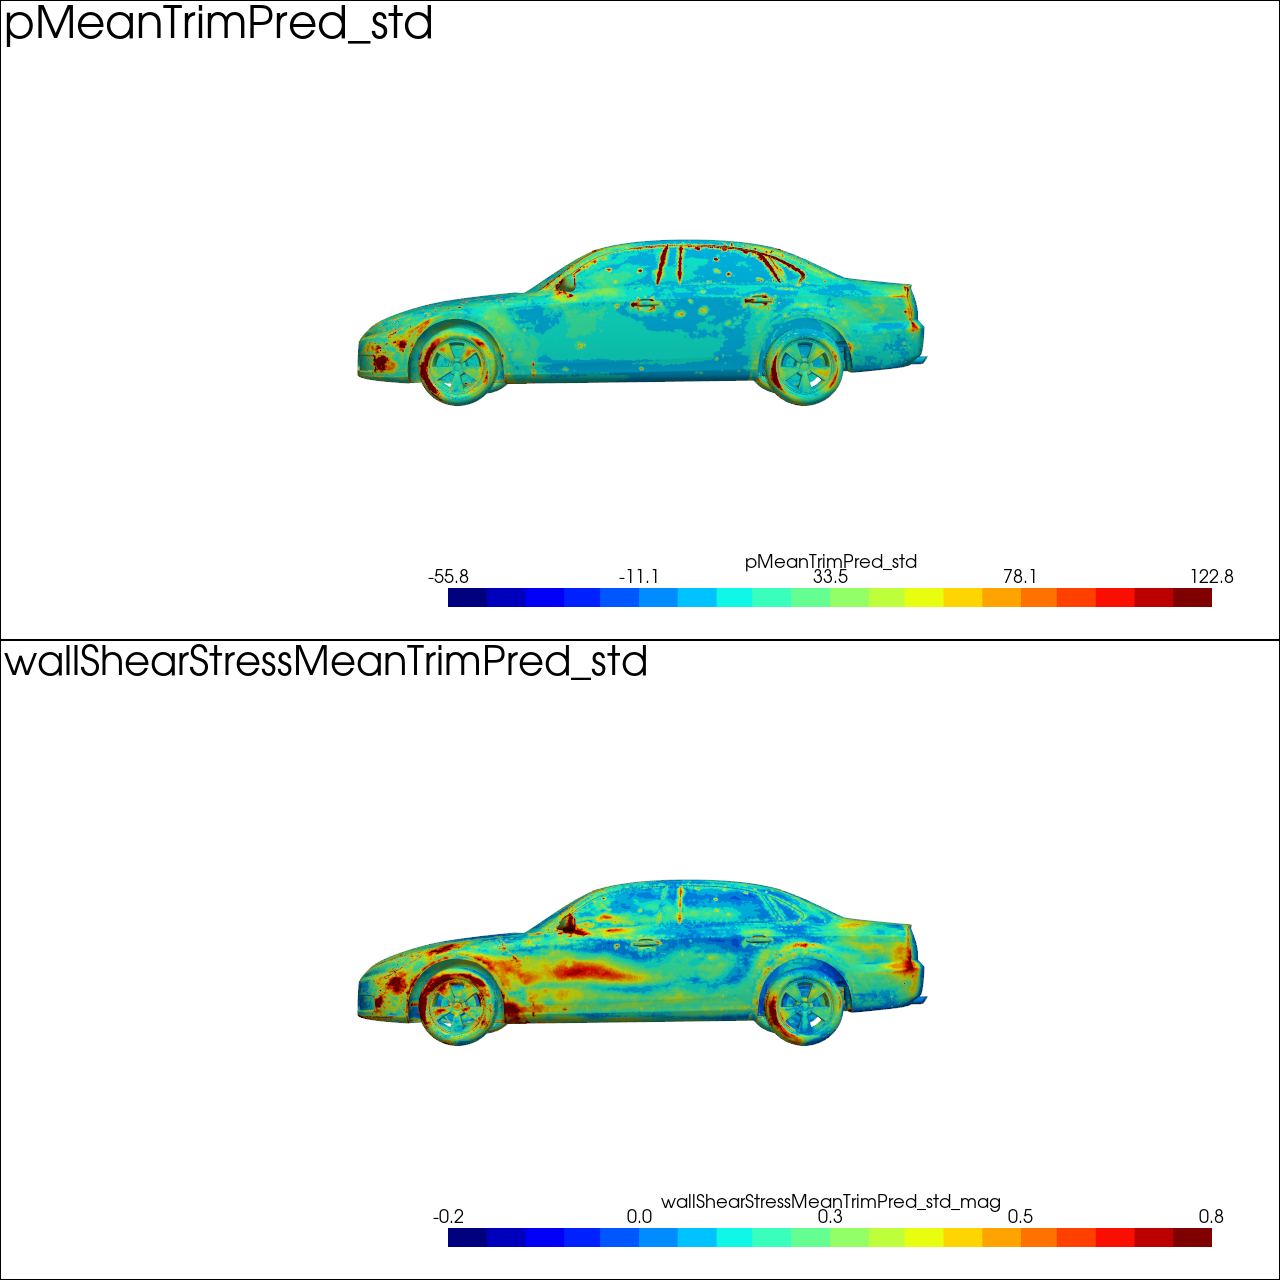

In [10]:
from physicsnemo.cfd.bench.visualization.utils import plot_fields

fields_to_plot = ["pMeanTrimPred_std", "wallShearStressMeanTrimPred_std"]
plotter = plot_fields(mesh, 
    fields_to_plot,
    plot_vector_components=False,
    view="xz",
    view_negative=False,
    dtype="cell",
    cmap="jet",
    lut=20,
    window_size=[1280, 1280],
)
plotter.screenshot("./variations_with_mesh_xz.png")

# Display the image
from IPython.display import Image

Image(filename="./variations_with_mesh_xz.png")

We can observe that just by changing the input STL resolution / re-meshing, the predictions of the model change. The fields show a high variance near the edges which is expected, as that is where the mesh changes, affect the topology. However, in addition to the edges, the model results also show high variance in areas where the topology does not change much, for example some areas of the roof, wheels and the sides of the car. 

## Analyze the model's sensitivity to checkpoint

AI models are trained using stochastic gradient descent and that leads to randomness in the model outputs. The model outputs can change based on when the model is checkpointed. Additionally, for a different input seed, the model can produce a different checkpoint. Typically this variation is limited as the learning rate at the end of the training is typically very small, however there are still some oscillaitons present. DoMINO NIM allows you to [bring custom checkpoints and perform inference](https://docs.nvidia.com/nim/physicsnemo/domino-automotive-aero/latest/advanced.html#inference-with-custom-checkpoints). One can use this functionality to save out last few checkpoints after the model training has reached "statistical" convergence, and then use them to produce an ensemble of results and study the variance as above. 

Since we don't ship various checkpoints with DoMINO, presently we directly present the results of such an analysis, however, the process to compute them would be similar as before, i.e. for the same input points, get the predictions of various model checkpoints and use them to build statistics. 

Below figure shows the results of such analysis. The analysis shows the standard deviation for pressure and wall shear stress for two samples from the validation set (439 on the left and 419 on the right).

![Variation due to model Checkpoint](img/variations_due_to_checkpoint.png)

We observe that, the a more variation is observed on the front, wheels and mirrors for the pressure, while for wall shear stress, the mirrors and wheels show a higher degree of sensitivity towards the model checkpoints.  

## Quantifying geometric similarity

The DoMINO model is trained on a diverse set of vehicle geometries that include different types of passenger automobiles like Vans, Pick-up trucks, SUVs, Sedans, etc. This means that the model is expected to perform well when the inference is computed on an unseen geometry from this class. On the contrary, a vehicle that is significantly out of distribution cannot be used for the inference. Quantifying whether a geometry is in-distribution or out-of-distribution can be hard for 3D shapes. To tackle this, we provide metrics to compute the relative distance between two geometries (chamfer distance and hausdorff distance). 

Below, we demonstrate how this can be used to build an understanding of the space of the training geometry data and get an estimate of how much the sample is "out-of-distribution". 

First to demonstrate, we will take two samples from DrivAerML dataset that are fairly close to one another, and then the AeroSUV sample. Our goal would be to quantitatively distinguish between these two samples. 

Below code will download the AeroSUV sample.

In [30]:
import os
import requests
import zipfile
import trimesh

zip_url = "https://www.ecara.org/fileadmin/media/dateien/AeroSUV/3_STL_Datensatz.zip"
zip_filename = "3_STL_Datensatz.zip"
extract_folder = "extracted_stl"
output_file = "merged_aerosuv.stl"

selected_stl_files = [
    "3_STL_Datensatz/01_body.stl",
    "3_STL_Datensatz/02_side-mirrors.stl",
    "3_STL_Datensatz/03_rear-end_estate.stl",
    "3_STL_Datensatz/08_underbody-flat.stl",
    "3_STL_Datensatz/02_side-mirrors.stl",
    "3_STL_Datensatz/17_wheels-front.stl",
    "3_STL_Datensatz/18_wheels-rear.stl",
    "3_STL_Datensatz/20_cooling-air-closing.stl",
]

print("Downloading ZIP...")
response = requests.get(zip_url)
with open(zip_filename, "wb") as f:
    f.write(response.content)
print("Download complete.")

os.makedirs(extract_folder, exist_ok=True)
print("Extracting selected STL files...")
with zipfile.ZipFile(zip_filename, "r") as zip_ref:
    for stl in selected_stl_files:
        try:
            zip_ref.extract(stl, extract_folder)
            print(f"Extracted: {stl}")
        except KeyError:
            print(f"File not found in ZIP: {stl}")
print("Extraction complete.")

mesh_list = []
for stl in selected_stl_files:
    stl_path = os.path.join(extract_folder, stl)
    if os.path.exists(stl_path):
        mesh = trimesh.load(stl_path, force='mesh')
        mesh_list.append(mesh)

if not mesh_list:
    raise ValueError("No valid STL files were loaded.")

print(f"Merging {len(mesh_list)} meshes...")
combined = trimesh.util.concatenate(mesh_list)

# Scale to bring it closer to DrivAerML STls. 
combined.apply_scale(1/254) 
combined.apply_translation([0, 0, -0.296])

combined.export(output_file)
print(f"Merged and scaled STL saved as '{output_file}'")


Download complete.
Extracting selected STL files...
Extracted: 3_STL_Datensatz/01_body.stl
Extracted: 3_STL_Datensatz/02_side-mirrors.stl
Extracted: 3_STL_Datensatz/03_rear-end_estate.stl
Extracted: 3_STL_Datensatz/08_underbody-flat.stl
Extracted: 3_STL_Datensatz/02_side-mirrors.stl
Extracted: 3_STL_Datensatz/17_wheels-front.stl
Extracted: 3_STL_Datensatz/18_wheels-rear.stl
Extracted: 3_STL_Datensatz/20_cooling-air-closing.stl
Extraction complete.
Merging 8 meshes...
Merged and scaled STL saved as 'merged_aerosuv.stl'


Next we will download the sample ID 418 and 420 as these are very similar to one another visually. 

In [31]:
filenames = [
    "drivaer_418.stl",
    "drivaer_420.stl",
]
urls = [
    "https://huggingface.co/datasets/neashton/drivaerml/resolve/main/run_418/drivaer_418.stl",
    "https://huggingface.co/datasets/neashton/drivaerml/resolve/main/run_420/drivaer_420.stl",
]

for filename, url in zip(filenames, urls):
    if not os.path.exists(filename):
        !wget "{url}" -O "{filename}"
    else:
        print(f"{filename} already exists. Skipping download.")

drivaer_418.stl already exists. Skipping download.
drivaer_420.stl already exists. Skipping download.


Let's visualize them together. 

ERROR:root:Could not find a decent config
2025-08-02 00:18:34.349 (3917.390s) [    7557909A4740]vtkXOpenGLRenderWindow.:256    ERR| vtkXOpenGLRenderWindow (0x7554394a6be0): Could not find a decent config

2025-08-02 00:18:34.350 (3917.391s) [    7557909A4740]vtkXOpenGLRenderWindow.:502   WARN| vtkXOpenGLRenderWindow (0x7554394a6be0): Could not find a decent visual

2025-08-02 00:18:34.351 (3917.392s) [    7557909A4740] vtkEGLRenderWindow.cxx:674   WARN| vtkEGLRenderWindow (0x7550c827fb30): Unable to eglMakeCurrent: 12291
2025-08-02 00:18:34.420 (3917.461s) [    7557909A4740] vtkEGLRenderWindow.cxx:674   WARN| vtkEGLRenderWindow (0x75504355b7a0): Unable to eglMakeCurrent: 12291


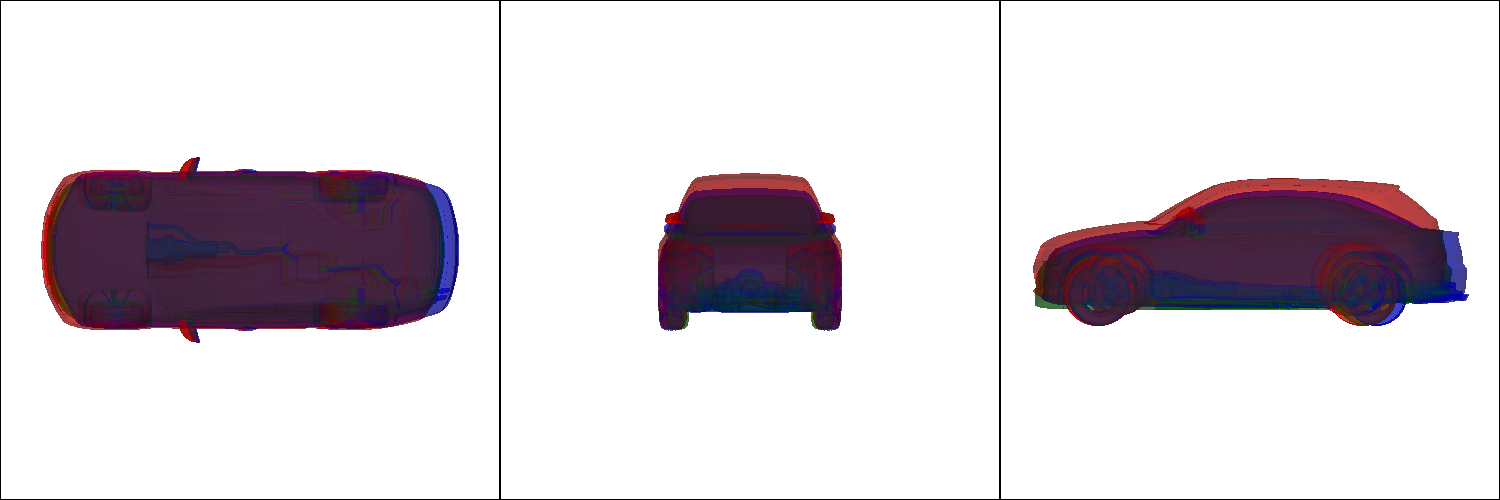

In [32]:
from turtle import window_height


aero_suv = pv.read("merged_aerosuv.stl")
sedan_1 = pv.read("drivaer_418.stl")
sedan_2 = pv.read("drivaer_420.stl")

plotter = pv.Plotter(shape=(1, 3), off_screen=True, window_size=(1500, 500))

def add_all_meshes(p, view_func):
    p.add_mesh(aero_suv, opacity=0.5, show_edges=False, color='red')
    p.add_mesh(sedan_1, opacity=0.5, show_edges=False, color='green')
    p.add_mesh(sedan_2, opacity=0.5, show_edges=False, color='blue')
    view_func()
    p.reset_camera()
    p.set_background("white")

plotter.subplot(0, 0)
add_all_meshes(plotter, plotter.view_xy)

plotter.subplot(0, 1)
add_all_meshes(plotter, plotter.view_yz)

plotter.subplot(0, 2)
add_all_meshes(plotter, plotter.view_xz)

plotter.set_background("white")
plotter.screenshot("./stl_comparisons.png")

# Display the image
from IPython.display import Image

Image(filename="./stl_comparisons.png")

Now let's compute the relative distances.

In [33]:
from physicsnemo.cfd.bench.geometry.distance import chamfer_distance, hausdorff_distance

sedan_1_vs_aerosuv = chamfer_distance(sedan_1.points, aero_suv.points)
sedan_2_vs_aerosuv = chamfer_distance(sedan_2.points, aero_suv.points)
sedan_1_vs_sedan_2 = chamfer_distance(sedan_1.points, sedan_2.points)
print(sedan_1_vs_aerosuv, sedan_2_vs_aerosuv, sedan_1_vs_sedan_2)

0.0576326009777469 0.05471310619482909 0.03239957394205294


In [34]:
sedan_1_vs_aerosuv = hausdorff_distance(sedan_1.points, aero_suv.points)
sedan_2_vs_aerosuv = hausdorff_distance(sedan_2.points, aero_suv.points)
sedan_1_vs_sedan_2 = hausdorff_distance(sedan_1.points, sedan_2.points)
print(sedan_1_vs_aerosuv, sedan_2_vs_aerosuv, sedan_1_vs_sedan_2)

0.37145597389151735 0.35232097572016974 0.19132546164645767


We observe that the distance (chamfer and hausdorff) between the two sedans is lower than the same between the SUV and either of the sedan. 

The distance measures can be used to make these relative distance queries and quantify the in-distribution vs. out-of-distribution nature of the sample. 

For example, below, we take a few samples from each class (SUV, Sedan, Pickup, Hatchback, Van) from the dataset that was used for the NIM training and compare it with the Sedans from DrivAerML. We see that the validation samples from the DrivAerML are the closest to the training samples from DrivAerML. This is followed by the Sedans from the DriveSim, Sportscars, Hatchback, Van and SUV from DriveSim. The most different are the Pickup trucks from DriveSim, which makes sense as that represents a significant geometric variation when compared to a sedan. 

![Chamfer Distances](img/chamfer-distances-drivaerml.png)